In [26]:
import pandas as pd
import os

df = pd.read_csv('./fit.dat', skiprows = 1, sep = ' ',index_col=False, header = None, names = ["iteration", "evaluation", "sigma", "axis ratio", "bestever", "best", "median", "worst objective function value", "further objective values of best", "X"])
row_num = df.shape[0]
dict1 = {"dim": row_num*[1],
        "func": row_num*[2],
        "method": row_num*[3],
        "rep_num": row_num*[4],
        "eval_num": df["evaluation"],
        "bestever": df["bestever"]}
pd.DataFrame(dict1)        

,dim,func,method,rep_num,eval_num,bestever
0,1,2,3,4,10,1.795710e+10
1,1,2,3,4,20,1.067512e+10
2,1,2,3,4,30,1.067512e+10
3,1,2,3,4,1010,5.273722e+04
4,1,2,3,4,2010,2.926036e+03
5,1,2,3,4,3010,2.702513e+02
6,1,2,3,4,4010,1.000001e+02
7,1,2,3,4,5010,1.000000e+02
8,1,2,3,4,5470,1.000000e+02


In [51]:
import pandas as pd
import numpy as np
import os
file_colnames =  ["iteration", "evaluation", "sigma", "axis ratio", "bestever", "best", "median", "Z", "Y", "X"]
rootPath = './outcmaes/50'

func_min = {}
func_max = {}
rows_list = []
for (dirpath,dirnames,files) in os.walk(rootPath):
    if files:
        head,rep = os.path.split(dirpath)
        head,method = os.path.split(head)
        head,func = os.path.split(head)
        head,dim = os.path.split(head)
        #print(rep,method,func,dim)
        dim = 50
        df = pd.read_csv(os.path.join(dirpath,'fit.dat'), skiprows = 1, sep = ' ',index_col=False, header = None, names = file_colnames)
        row_num = df.shape[0]
        dict1 = {"dim": row_num*[dim],
                "func": row_num*[func],
                "method": row_num*[method],
                "rep_num": row_num*[rep],
                "eval_num": df["evaluation"],
                "bestever": df["bestever"]}
        rows_list.append(pd.DataFrame(dict1))
        
        locmin = np.min(df["bestever"])
        locmax = np.max(df["bestever"])
        if func in func_min:
            min1 = func_min[func]
            if locmin < min1:
                func_min[func] = locmin
        else:
            func_min[func] = locmin
            
        if func in func_max:
            max1 = func_max[func]
            if locmax > max1:
                func_max[func] = locmax
        else:
            func_max[func] = locmax
        
resDF = pd.concat(rows_list)
resDF = resDF.reset_index(drop=True)

In [52]:
pd.set_option('display.max_rows', 500)
import math
def log(x,base):
    return np.log10(x)/np.log10(base)

def reindex_eval_percent(df):
    eval_percents = pd.Index(np.arange(0,101,1), name = "eval_percent")
    df = df.set_index("eval_percent")
    return df.reindex(eval_percents).ffill().reset_index()
    

dim = 50
base = math.pow(10,0.2)
MaxFE = 1e4 * dim
resDF = resDF.assign(eval_percent=(np.floor(100*resDF["eval_num"]/MaxFE)))
resDF = resDF.assign(min_val= resDF["func"].map(func_min))
resDF = resDF.assign(max_val= resDF["func"].map(func_max))
resDF = resDF.assign(target_percent=
                     (np.ceil(log(resDF["max_val"],base))- np.ceil(log(resDF["bestever"],base)))
                     / (np.ceil(log(resDF["max_val"],base))- np.ceil(log(resDF["min_val"],base))))


# avgRes
avgRes = resDF.groupby(["dim","func","method","rep_num","eval_percent"]).mean().reset_index() 
avgRes = avgRes.drop(columns = ["eval_num","bestever","min_val","max_val"]) #drop columns with false info or unused
avgRes = avgRes.groupby(["dim","func","method","rep_num"]).apply(reindex_eval_percent).reset_index(drop = True)
avgRes = avgRes.groupby(["dim","func","method", "eval_percent"]).mean().reset_index()
#avgRes = avgRes.drop(columns = ["rep_num"])
avgRes

,dim,func,method,eval_percent,target_percent
0,50.0,1,CSA,0,0.232569
1,50.0,1,CSA,1,0.805278
2,50.0,1,CSA,2,0.810417
3,50.0,1,CSA,3,0.881771
4,50.0,1,CSA,4,0.907326
...,...,...,...,...,...
8782,50.0,9,TPA,96,0.898182
8783,50.0,9,TPA,97,0.898182
8784,50.0,9,TPA,98,0.898182
8785,50.0,9,TPA,99,0.898182


In [1]:
import seaborn as sns

sns.lineplot(x = "eval_percent", y = "target_percent",  hue = "method", data = avgRes[avgRes["func"] == '13'])

NameError: name 'avgRes' is not defined

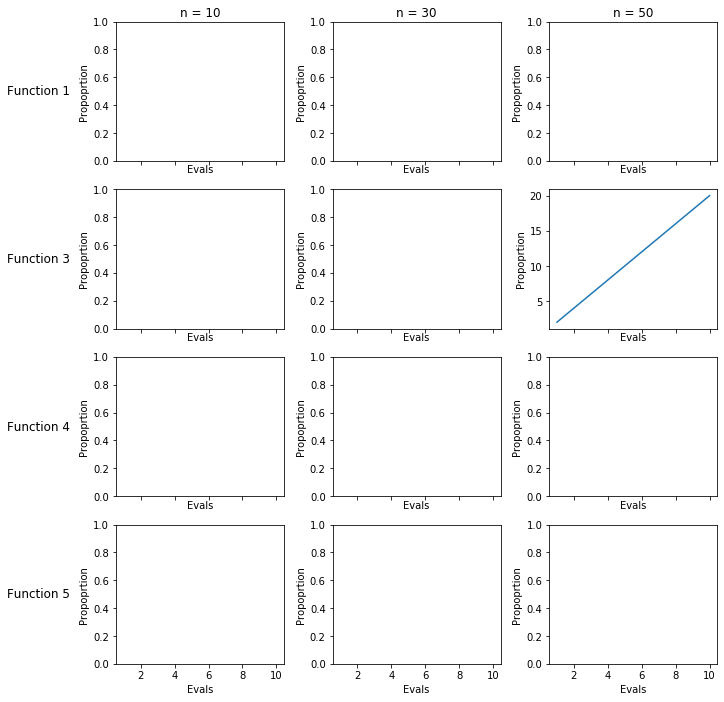

In [1]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy


cols = ['n = {}'.format(col) for col in [10, 30, 50]]
rows = ['Function {}'.format(row) for row in range(1,6) if row not in [2]]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10), sharex = True)
plt.setp(axes.flat, xlabel='Evals', ylabel='Propoprtion')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    

axes[1,2].plot(range(1,11), range(2,22,2)) #dodawanie wykresów. Indeksujesz po tablicy wykresów

fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.95)

plt.show()